In [1]:
import pymc3 as pm
import matplotlib

`with`문을 통해서 `model` 내 변수 선언이 편해짐.
- 여기 안에서 (context라고 표현함) 선언된 변수는 `model`에 대한 속성으로 assign됨
- 밖에서 선언하면 error가 발생함

In [2]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

In [3]:
model.__dict__

{'_parent': None,
 '_theano_config': {'compute_test_value': 'raise'},
 '_config_context': <theano.configparser._ChangeFlagsDecorator at 0x7f7b8302d3a0>,
 'name': '',
 'coords': {},
 'RV_dims': {},
 'check_bounds': True,
 'named_vars': {'poisson_param_log__': poisson_param_log__ ~ TransformedDistribution,
  'poisson_param': poisson_param ~ Exponential,
  'data_generator': data_generator ~ Poisson},
 'free_RVs': [poisson_param_log__ ~ TransformedDistribution,
  data_generator ~ Poisson],
 'observed_RVs': [],
 'deterministics': [poisson_param ~ Exponential],
 'potentials': [],
 'missing_values': [],
 'poisson_param_log__': poisson_param_log__ ~ TransformedDistribution,
 'poisson_param': poisson_param ~ Exponential,
 'data_generator': data_generator ~ Poisson}

In [4]:
parameter.tag.test_value

array(0.69314718)

다시 `with model`로 부를 수 있음

In [6]:
with model:
    data_plus_one = data_generator + 1

In [7]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

In [8]:
theta.tag.test_value

array(0.34657359)

In [9]:
data_generator.tag.test_value

array(0)

In [10]:
model.contexts

In [11]:
model.__dict__

{'_parent': None,
 '_theano_config': {'compute_test_value': 'raise'},
 '_config_context': <theano.configparser._ChangeFlagsDecorator at 0x7f7b704417c0>,
 'name': '',
 'coords': {},
 'RV_dims': {},
 'check_bounds': True,
 'named_vars': {'theta_log__': theta_log__ ~ TransformedDistribution,
  'theta': theta ~ Exponential,
  'data_generator': data_generator ~ Poisson},
 'free_RVs': [theta_log__ ~ TransformedDistribution, data_generator ~ Poisson],
 'observed_RVs': [],
 'deterministics': [theta ~ Exponential],
 'potentials': [],
 'missing_values': [],
 'theta_log__': theta_log__ ~ TransformedDistribution,
 'theta': theta ~ Exponential,
 'data_generator': data_generator ~ Poisson}

In [12]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

## PyMC3 variables

`test_value`는 model에만 쓰이며, sampling의 스타트 포인트이다.

In [13]:
# test values (=initial values)
print(parameter.tag.test_value)
print(data_generator.tag.test_value)
print(data_plus_one.tag.test_value)

0.6931471824645996
0
1


In [14]:
# testval 지정도 가능
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

parameter.tag.test_value

array(0.5)

PyMC3의 변수는 두가지가 있다. `deterministic`한 변수와 `stochastic`한 변수.

### stochastic 변수 init

```python
some_variable = pm.SomeDistribution(name, *params)
```

### deterministic 변수

#### 기본적인 operator로 implicit 하게 선언하기

In [15]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", 0, 10)

implicit_deteremined = lambda_1 + lambda_2

In [16]:
implicit_deteremined

Elemwise{add,no_inplace}.0

#### `pm` 내 함수로 explicit 하게 선언하기

In [17]:
import numpy as np

n_data_points = 5
idx = np.arange(n_data_points)

with model:
    # Elemwise 조건이 true이면 A, false이면 B
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

이런 식으로 아예 `pm.Deterministic`을 불러올 수도 있음
```python
stochastic_1 = pm.Uniform("U_1", *arg1)
stochastic_2 = pm.Uniform("U_2", *arg2)

det_1 = pm.Deterministic("delta", some_func(stochastic_1, stochastic_2))
```

## theano tensor

In [18]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    # np.stack과 비슷
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

In [19]:
print(p1.tag.test_value)
print(p2.tag.test_value)
print(p.tag.test_value)

0.5
0.5
[0.5 0.5]


## observations in the model

In [20]:
import matplotlib.pyplot as plt
import scipy.stats as stats

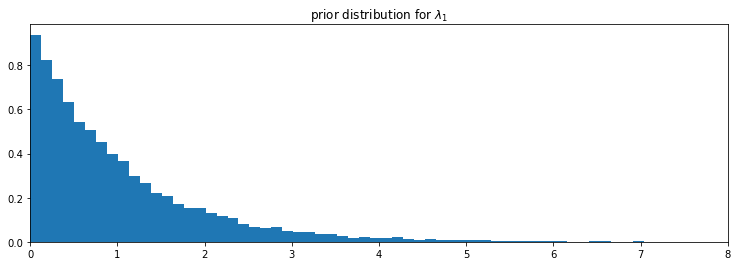

In [21]:
samples = lambda_1.random(size=20000)
plt.figure(figsize=(12.5, 4))
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("prior distribution for $\lambda_1$")
plt.xlim(0, 8);

모델에 측정값을 입력하려면 `observed`에 데이터를 넣어주면 된다.

In [22]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


In [23]:
data = np.array([10, 25, 15, 20, 15])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 15]


In [24]:
obs

obs ~ Poisson

## Example: Bayesian A/B testing

A 웹사이트에 $N$명이 들어와서 $n$명이 구매 $\rightarrow p_A=\frac{n}{N}$  
일단 $p_A$를 균등분포 prior로 가정하자

In [25]:
with pm.Model() as model:
    p = pm.Uniform("p", 0, 1)

In [26]:
# p_true 값을 잘 추정할 수 있는지 확인해보자
p_true = 0.05  # hidden
N = 1500

# sampling
occurences = stats.bernoulli.rvs(p_true, size=N)

print(occurences)
print(np.sum(occurences))

[0 0 0 ... 0 0 0]
83


In [27]:
p_true * N

75.0

In [28]:
# Metropolis 시뮬레이션 시작
with model:
    obs = pm.Bernoulli("obs", p, observed=occurences)
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

/var/folders/m2/xl06qxf96958pj9c450dz5nc0000gn/T/ipykernel_1406/3924705020.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(18000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


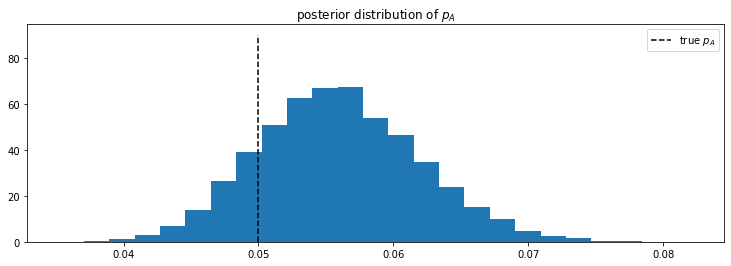

In [29]:
plt.figure(figsize=(12.5, 4))
plt.title("posterior distribution of $p_A$")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$", color="black")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend();

이번에 두가지를 비교해보자.  
A 웹사이트에 $N_A$명이 들어와서 $n_A$명이 구매 $\rightarrow p_A=\frac{n_A}{N_A}$  
B 웹사이트에 $N_B$명이 들어와서 $n_B$명이 구매 $\rightarrow p_B=\frac{n_B}{N_B}$

In [30]:
burned_trace["p"].mean()

0.05593365854837887

In [31]:
# p_true 값들과, delta = p_A - p_B 를 추정해보자
p_A_true = 0.05
p_B_true = 0.04

# 샘플 사이즈는 서로 다르다.
N_A = 1500
N_B = 750

observed_A = stats.bernoulli.rvs(p_A_true, size=N_A)
observed_B = stats.bernoulli.rvs(p_B_true, size=N_B)

print(np.mean(observed_A))
print(np.mean(observed_B))

0.05533333333333333
0.029333333333333333


In [32]:
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    delta = pm.Deterministic("delta", p_A - p_B)
    
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observed_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observed_B)
    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]

/var/folders/m2/xl06qxf96958pj9c450dz5nc0000gn/T/ipykernel_1406/2734986633.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(20000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [33]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

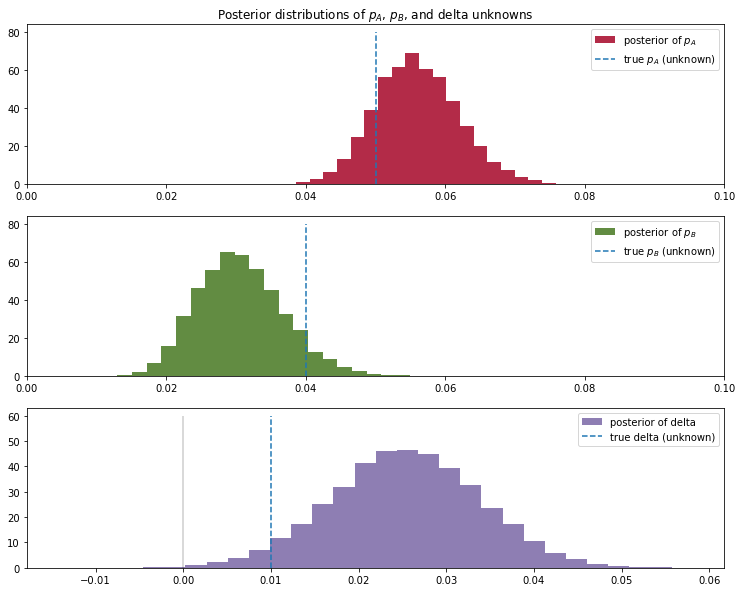

In [34]:
plt.figure(figsize=(12.5, 10))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(p_A_true, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(p_B_true, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(p_A_true - p_B_true, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [35]:
np.mean(delta_samples < 0)  # p_A - p_B < 0일 확률

0.002105263157894737

## Example: 거짓말에 대한 알고리즘

### 알고리즘 소개 
- 프라이버시는 지키면서 솔직하게 대답을 듣기 위한 알고리즘
- 부정행위가 일어난 빈도를 확인하고 싶다.
1. 인터뷰 전에 학생들에게 동전을 던지게 한다. 
2. 동전 던지기 결과에 따라 참/거짓이 달라진다.
    - H: 솔직하게 말한다. (참만 말한다.)
    - T: 다시 한번 동전을 던져서 그 결과로만 말한다. (랜덤)
        - H2: 부정행위를 했다고 말한다. (대신 처벌받진 않는다.)
        - T2: 부정행위를 안했다고 말한다. (부정행위 했더라도 이렇게 대답한다.)

### 모델링
- 전체 학생 $N$
- 부정행위가 일어난 비율 $p$
- 부정행위에 대한 likelihoood $X \sim \mathrm{Bin}(N, p)$
- 첫번째, 두번째 코인 토스에서 Head $X_1, X_2 \sim \mathrm{Bin}(N, 0.5)$
- 첫번째 코인 토스 때 H라서 사실대로 말한 경우
    - $x \cdot x_1$
- 첫번째 코인이 T고, 두번째 코인 토스에서는 H라서 부정행위를 했다고 말한 경우
    - $(1 - x_1) \cdot x_2$
- "부정행위를 했습니다."라고 측정되는 확률변수
    - $\text{obs} = x \cdot x_1 + (1 - x_1) \cdot x_2$

In [36]:
with pm.Model() as model:
    N = 100
    p = pm.Uniform("freq_cheating", 0, 1)
    cheat = pm.Bernoulli("cheat", p, shape=N, testval=np.random.binomial(1, 0.5, N))
    x1 = pm.Bernoulli("first_coin", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    x2 = pm.Bernoulli("second_coin", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    obs_array = cheat * x1 + (1 - x1) * x2
    obs_prop = pm.Deterministic("obs_prop", tt.sum(obs_array) / float(N))

In [37]:
obs_prop.tag.test_value * N

50.999999046325684

In [38]:
X = 35
with model:
    obs = pm.Binomial("obs", N, obs_prop, observed=X)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

/var/folders/m2/xl06qxf96958pj9c450dz5nc0000gn/T/ipykernel_1406/4224314261.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(40000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [cheat, first_coin, second_coin]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 400 seconds.
The number of effective samples is smaller than 10% for some parameters.


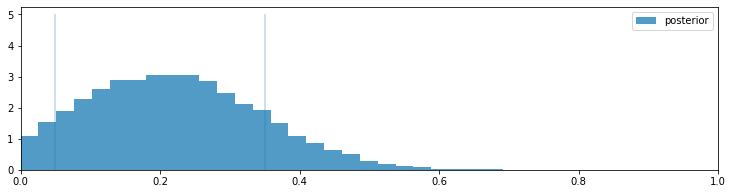

In [40]:
plt.figure(figsize=(12.5, 3))
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30,
         label="posterior", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

### 모델링을 다르게

$$ P("Yes") = P(H1)P(cheat) + P(T1)P(H2)$$
$$ P("Yes") = p/2 + 1/4$$

In [41]:
with pm.Model() as model_alter:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)
    yes_resposes = pm.Binomial("number_cheaters", N, p_skewed, observed=X)
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    burned_trace = trace[2500:]

/var/folders/m2/xl06qxf96958pj9c450dz5nc0000gn/T/ipykernel_1406/618680817.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(25000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [freq_cheating]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


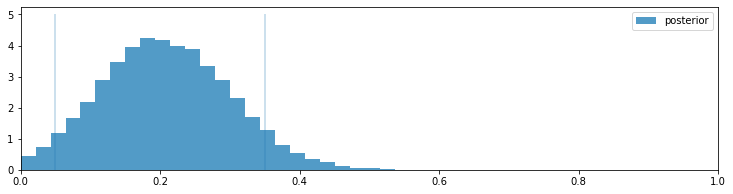

In [42]:
plt.figure(figsize=(12.5, 3))
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30,
         label="posterior", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

## 챌린저호 오링 문제

In [43]:
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("datasets/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")

In [44]:
challenger_data

array([[66.,  0.],
       [70.,  1.],
       [69.,  0.],
       [80., nan],
       [68.,  0.],
       [67.,  0.],
       [72.,  0.],
       [73.,  0.],
       [70.,  0.],
       [57.,  1.],
       [63.,  1.],
       [70.,  1.],
       [78.,  0.],
       [67.,  0.],
       [53.,  1.],
       [67.,  0.],
       [75.,  0.],
       [70.,  0.],
       [81.,  0.],
       [76.,  0.],
       [79.,  0.],
       [75.,  1.],
       [76.,  0.],
       [58.,  1.],
       [31., nan]])

In [45]:
# drop NA
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

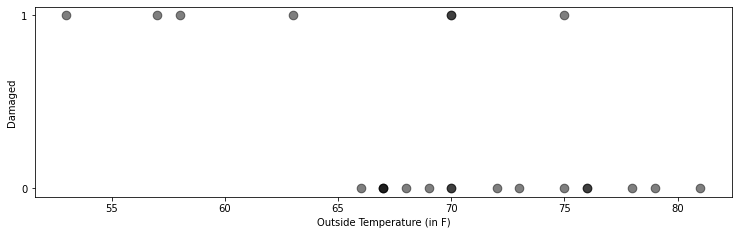

In [46]:
plt.figure(figsize=(12.5, 3.5))
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k", alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damaged")
plt.xlabel("Outside Temperature (in F)");

In [47]:
def logistic(x, beta):
    return 1 / (1 + np.exp(beta * x))

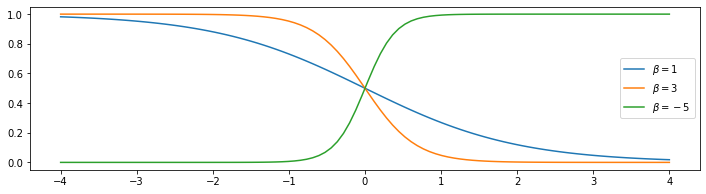

In [48]:
plt.figure(figsize=(12, 3))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta=1$")
plt.plot(x, logistic(x, 3), label=r"$\beta=3$")
plt.plot(x, logistic(x, -5), label=r"$\beta=-5$")
plt.legend();

 - logistic
 $$ p(t) = \frac{1}{1 + e^{\beta t + \alpha}} $$

In [49]:
def logistic(x, beta, alpha):
    return 1 / (1 + np.exp(np.dot(beta, x) + alpha))

In [50]:
temp = challenger_data[:, 0]
D = challenger_data[:, 1]  # Defect or Not

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1 / (1 + tt.exp(beta*temp + alpha)))
    observed = pm.Bernoulli("bernouilli_obs", p, observed=D)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

/var/folders/m2/xl06qxf96958pj9c450dz5nc0000gn/T/ipykernel_1406/4135964653.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(120000, step=step, start=start)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 4 chains for 1_000 tune and 120_000 draw iterations (4_000 + 480_000 draws total) took 40 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [51]:
alpha_samples = burned_trace["alpha"][:, np.newaxis]
beta_samples = burned_trace["beta"][:, np.newaxis]

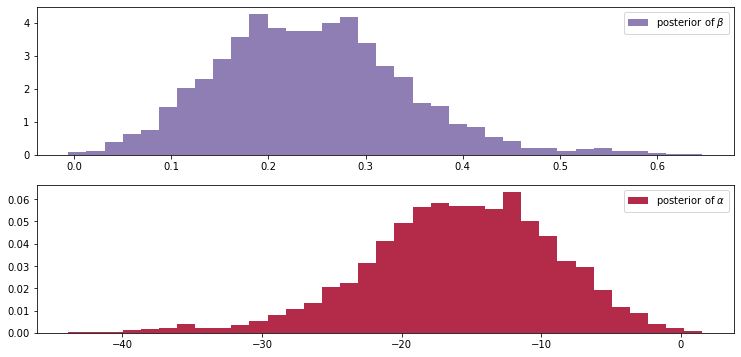

In [52]:
plt.figure(figsize=(12.5, 6))

plt.subplot(211)
plt.hist(beta_samples, histtype="stepfilled", bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype="stepfilled", bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.legend();

In [53]:
beta_samples

array([[0.366],
       [0.366],
       [0.344],
       ...,
       [0.331],
       [0.341],
       [0.341]])

In [54]:
t = np.linspace(temp.min() - 5, temp.max() + 5, 50)[:, np.newaxis]  # plotting mesh
p_t = logistic(t.T, beta_samples, alpha_samples)
mean_prob_t = p_t.mean(axis=0)

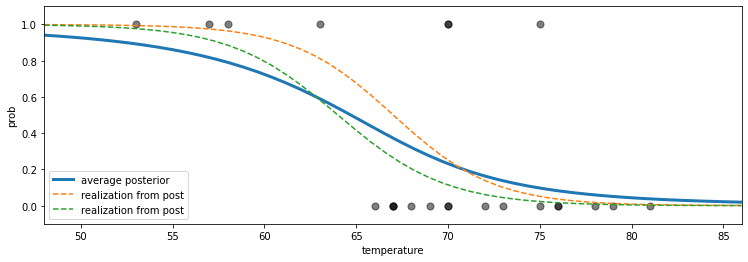

In [55]:
plt.figure(figsize=(12.5, 4))

plt.plot(t, mean_prob_t, lw=3, label="average posterior")
plt.plot(t, p_t[0, :], ls="--", label="realization from post")
plt.plot(t, p_t[-2, :], ls="--", label="realization from post")
plt.scatter(temp, D, color="k", s=50, alpha=0.5)
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("prob")
plt.xlabel("temperature");

In [60]:
qs

masked_array(
  data=[[0.625, 0.61 , 0.596, 0.579, 0.563, 0.547, 0.532, 0.514, 0.497,
         0.479, 0.462, 0.444, 0.428, 0.409, 0.389, 0.371, 0.352, 0.332,
         0.309, 0.287, 0.264, 0.24 , 0.215, 0.189, 0.165, 0.141, 0.117,
         0.096, 0.077, 0.06 , 0.047, 0.036, 0.027, 0.02 , 0.015, 0.011,
         0.008, 0.006, 0.004, 0.003, 0.002, 0.001, 0.001, 0.001, 0.001,
         0.   , 0.   , 0.   , 0.   , 0.   ],
        [1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.998, 0.998, 0.997,
         0.995, 0.994, 0.991, 0.988, 0.983, 0.976, 0.967, 0.955, 0.938,
         0.917, 0.889, 0.855, 0.814, 0.767, 0.716, 0.662, 0.61 , 0.558,
         0.51 , 0.468, 0.43 , 0.396, 0.367, 0.341, 0.318, 0.298, 0.279,
         0.262, 0.246, 0.232, 0.22 , 0.208, 0.196, 0.184, 0.174, 0.165,
         0.156, 0.147, 0.139, 0.132, 0.126]],
  mask=False,
  fill_value=1e+20)

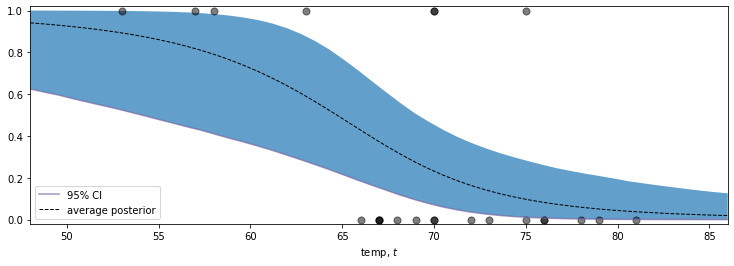

In [61]:
from scipy.stats.mstats import mquantiles

plt.figure(figsize=(12.5, 4))

qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7)

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
plt.plot(t, mean_prob_t, lw=1, ls="--", color="k", 
         label="average posterior")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temp, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$");

In [62]:
# prob when Temp = 31
prob_31 = logistic(31, beta=beta_samples, alpha=alpha_samples)

In [67]:
prob_31.shape

(40000, 1)

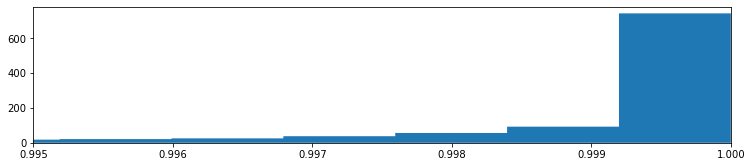

In [65]:
plt.figure(figsize=(12.5, 2.5))

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, density=True, histtype="stepfilled");

## 우리 모델이 맞는걸까?

1만번 돌려보기

In [68]:
N = 10000
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0 / (1. + tt.exp(beta * temp + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

/var/folders/m2/xl06qxf96958pj9c450dz5nc0000gn/T/ipykernel_1406/3990140142.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(N, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>BinaryGibbsMetropolis: [bernoulli_sim]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [70]:
simulations = trace["bernoulli_sim"]
print(simulations.shape)

(40000, 23)


In [71]:
simulations

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1]])

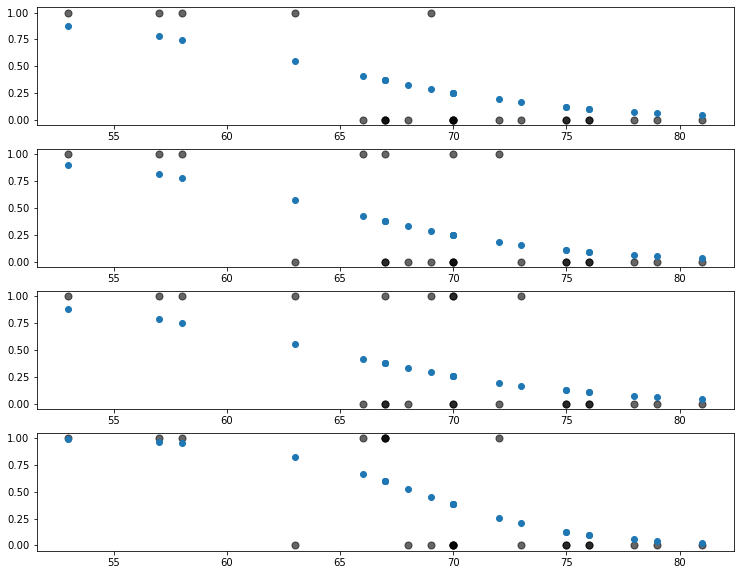

In [92]:
plt.figure(figsize=(12.5, 10))

p_trace = trace["p"]
alpha_trace = trace["alpha"]
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temp, simulations[1000*i, :], color="k", s=50, alpha=0.6)
    plt.scatter(temp, p_trace[1000*i, :])

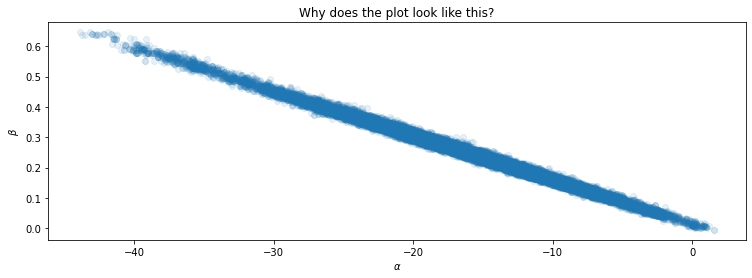

In [94]:
plt.figure(figsize=(12.5, 4))

plt.scatter(alpha_samples, beta_samples, alpha=0.1)
plt.title("Why does the plot look like this?")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$");